In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
FIRST_TIME=False
TRAIN=False
TEST=True

In [0]:
if FIRST_TIME:
    from google.colab import files
    files.upload() #this will prompt you to upload the kaggle.json
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    # we need to set permissions 
    !chmod 600 /root/.kaggle/kaggle.json
    # Download dataset for the first time
    !kaggle datasets download -d emmarex/plantdisease # api copied from kaggle
    # Unzip the zip file for thet first time
    !unzip -q "/content/gdrive/My Drive/Kaggle/Plant Disease/plantdisease.zip"


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Plant Disease Detection/Kaggle')#change dir

In [0]:
%tensorflow_version 1.x
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import PIL
from PIL import Image
!pip install image

In [0]:
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/gdrive/My Drive/Plant Disease Detection/Kaggle'
width=256
height=256
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
if TRAIN: 
    image_list, label_list = [], []
    try:
        print('[INFO] Loading images ...')
        root_dir = listdir(directory_root)
        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
            
            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"[INFO] Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                    
                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)

                for image in plant_disease_image_list[:200]:
                    image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                        image_list.append(convert_image_to_array(image_directory))
                        label_list.append(plant_disease_folder)
        print("[INFO] Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")

In [0]:
if TRAIN: 
    image_size = len(image_list)
    label_binarizer = LabelBinarizer()
    image_labels = label_binarizer.fit_transform(label_list)
    pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
    n_classes = len(label_binarizer.classes_)

In [10]:
if TEST: 
    loaded_model = pickle.load(open('label_transform.pkl', 'rb'))
    print(loaded_model)
    

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
if TRAIN: 
    np_image_list = np.array(image_list, dtype=np.float16) / 225.0
    print("[INFO] Spliting data to train, test")
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

    aug = ImageDataGenerator(
        rotation_range=25, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, 
        zoom_range=0.2,horizontal_flip=True, 
        fill_mode="nearest")


In [0]:
if TRAIN: 
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    # print the model architecture
    model.summary()

In [0]:
if TRAIN: 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    # train the network
    print("[INFO] training network...")
    # Start training 
    history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

    # Plot accuracy and training loss
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()
    plt.figure()

    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    #Evalution 
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [0]:
if TRAIN: 
    # save the model to disk
    print("[INFO] Saving model...")
    pickle.dump(model,open('cnn_model.pkl', 'wb'))

In [20]:
!ls

'00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'   plantdisease.zip
 cnn_model.pkl						  plantvillage
 label_transform.pkl


In [0]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    
    plt.imshow(plt.imread(image))
    '''
    image = Image.open(image)
    plt.imshow(image)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
    '''

Pepper__bell___healthy


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


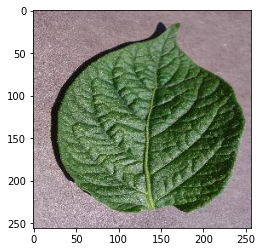

In [29]:
if TEST: 
    A_image='00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'
    image_array=convert_image_to_array(A_image).reshape(1,256,256,3)
    saved_model=pickle.load(open('cnn_model.pkl','rb'))
    prediction=saved_model.predict(image_array)
    label_binarizer=pickle.load(open('label_transform.pkl', 'rb'))
    print(f'{label_binarizer.inverse_transform(prediction)[0]}')
    imshow(A_image)
